## Лабораторна робота. Логістична регресія

## 1
Розглянемо дані медичної страхової фірми. На основі характеристик пацієнтів `Members.csv` (вік, стать) та даних про отримання медичного обслуговування в попередньому році `Claims_Y1.csv` (медичний заклад, лікар, тип проблеми, кількість днів госпіталізації, дата та ін.) потрібно передбачити факт госпіталізації хоча б на 1 день наступного року `DaysInHospital_Y2.csv`.


In [145]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

Прочитайте дані, в якості параметру index_col використовуйте `MemberID`.

* дані з таблиці 'DaysInHospital_Y2.csv' у змінну `days2`
* дані з таблиці 'Members.csv' до змінної `m`
* дані з таблиці 'Claims_Y1.csv' у змінну `claims`

In [6]:
days2 = pd.read_csv('DaysInHospital_Y2.csv', index_col='MemberID')
m = pd.read_csv('Members.csv', index_col='MemberID')
claims = pd.read_csv('Claims_Y1.csv', index_col='MemberID')

In [8]:
claims

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,0,8- 9 months,NEUMENT,0,MED,0
1,99829076,6721023.0,265273.0,91972.0,Y1,Rehabilitation,Office,162+,0,0- 1 month,TRAUMA,0,MED,0
2,54666321,9932074.0,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,0,0- 1 month,RESPR4,0,RAD,0
3,66951188,4699470.0,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,0,0- 1 month,ROAMI,0,RAD,0
4,78859054,9121540.0,523791.0,21579.0,Y1,Emergency,Urgent Care,22,1,6- 7 months,HEART2,0,SDS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865684,98535515,7638907.0,559727.0,83829.0,Y1,Emergency,Urgent Care,44,0,7- 8 months,TRAUMA,0,EM,0
865685,1344508,4107701.0,164823.0,78718.0,Y1,Laboratory,Independent Lab,17,0,NaN,CATAST,0,SCS,0
865686,73820095,1256697.0,789572.0,821.0,Y1,Surgery,Office,35,0,5- 6 months,MSC2a3,1,MED,0
865687,22476463,7053364.0,240043.0,70171.0,Y1,Laboratory,Independent Lab,38,0,0- 1 month,MSC2a3,0,PL,0


In [7]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865689 entries, 42286978 to 57805129
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ProviderID             860767 non-null  float64
 1   Vendor                 857799 non-null  float64
 2   PCP                    863296 non-null  float64
 3   Year                   865689 non-null  object 
 4   Specialty              863148 non-null  object 
 5   PlaceSvc               863117 non-null  object 
 6   PayDelay               865689 non-null  object 
 7   LengthOfStay           22475 non-null   object 
 8   DSFS                   849739 non-null  object 
 9   PrimaryConditionGroup  861977 non-null  object 
 10  CharlsonIndex          865689 non-null  object 
 11  ProcedureGroup         864567 non-null  object 
 12  SupLOS                 865689 non-null  int64  
dtypes: float64(3), int64(1), object(9)
memory usage: 92.5+ MB


## 2
Щоб анонімізувати дані організатор вказав приблизну інформацію про пацієнтів, наприклад, у стовпці вік зазначені вікові групи: '0-9', '10-19', '20-29', '30-39', '40-49', '50 -59', '60-69', '70-79', '80+'. Перетворимо рядкові ознаки на кількісні та замінимо пропущені значення:  AgeAtFirstClaim - значенням -1, Sex - N, LengthOfStay - 0.


In [8]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i, 'AgeAtFirstClaim'] = m.loc[i, 'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s != '80+' else '80')
m.loc[i, 'AgeAtFirstClaim'] = m.loc[i, 'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(-1).infer_objects(copy=False)

m.Sex = m.Sex.fillna('N').infer_objects(copy=False)

claims.LengthOfStay = claims.LengthOfStay.fillna('0').infer_objects(copy=False)

claims.CharlsonIndex = claims.CharlsonIndex.map({
    '0': 0,
    '1-2': 1,
    '3-4': 3,
    '5+': 5
})

claims.LengthOfStay = claims.LengthOfStay.map({
    0: 0,
    '1 day': 1,
    '2 days': 2,
    '3 days': 3,
    '4 days': 4,
    '5 days': 5,
    '6 days': 6,
    '1- 2 weeks': 10,
    '2- 4 weeks': 21,
    '4- 8 weeks': 42,
    '26+ weeks': 182
})


C:\Users\NortonFire\AppData\Local\Temp\ipykernel_18168\1216335815.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(-1).infer_objects(copy=False)


## 3
Сконструюємо ознаки по масиву випадків медичного обслуговування:
* `f_Charlson` - максимальний індекс коморбідності Чальсона з усіх випадків для пацієнта (`CharlsonIndex` у таблиці `claims`)
* `f_LengthOfStay` - сумарна кількість днів госпіталізації минулого року (`LengthOfStay` у таблиці `claims`)

*Функції, які можуть стати в нагоді при розв'язанні: `.groupby(['MemberID']), .max(), .sum()`*

In [19]:
f_Charlson = claims.groupby('MemberID')['CharlsonIndex'].max().reset_index()
f_LengthOfStay = claims.groupby('MemberID')['LengthOfStay'].sum().reset_index()

In [20]:
f_Charlson.set_index('MemberID', inplace=True)
f_LengthOfStay.set_index('MemberID', inplace=True)

In [21]:
f_LengthOfStay

,LengthOfStay
MemberID,
210,2.0
3197,0.0
3889,3.0
4187,0.0
9063,0.0
...,...
99995554,0.0
99996214,0.0
99997485,0.0


In [22]:
f_Charlson

,CharlsonIndex
MemberID,
210,0
3197,0
3889,1
4187,0
9063,0
...,...
99995554,0
99996214,0
99997485,0


## 4

Складемо матрицю об'єктів ознак зі стовпцями: `f_Charlson`, `f_LengthOfStay`, вік пацієнта, `ClaimsTruncated` (не виявилося випадків медичного обслуговування занадто багато):

*Функції, які можуть стати в нагоді при вирішенні: `.join()`*


In [138]:
data = days2

claims_trunc = data[['ClaimsTruncated']]
m_1 = m[['AgeAtFirstClaim']].join([f_Charlson, f_LengthOfStay])
data = data.join(m_1)
data = data.fillna(0)

data.head(5)

,ClaimsTruncated,DaysInHospital,AgeAtFirstClaim,CharlsonIndex,LengthOfStay
MemberID,,,,,
98324177,0,0,30,0.0,0.0
33899367,1,1,80,0.0,0.0
5481382,0,1,20,0.0,0.0
69908334,0,0,60,0.0,0.0
29951458,0,0,40,0.0,0.0


## 5
Складемо функцію, яка ділитиме вибірку на дві частини `dataTrain` та `dataTest`, буде навчати логістичну регресію на `dataTrain`, застосовувати до `dataTest`, будувати криву помилок і рахувати під нею площу:


In [118]:
def calcAUC(data):
    dataTrain, dataTest = train_test_split(data, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital)
    predictionProb = model.predict_proba(dataTest.loc[:, dataTest.columns != 'DaysInHospital'])
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print(metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:, 1]))

## 6
Застосуємо цю функцію до `data`:

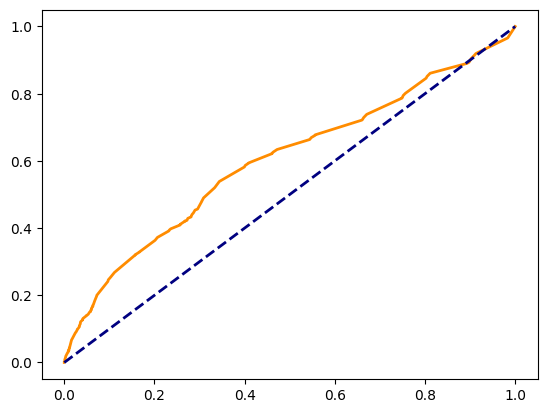

0.6020284726800841


In [119]:
calcAUC(data)

## 7

Логістична регресія приймає на вхід лише кількісні ознаки.

Додамо до наших даних стать пацієнта, застосувавши one hot encoding (ознайомитеся з даним методом кодування, опишіть його недоліки та переваги):

*Функції, які можуть стати в нагоді при розв'язанні: `pd.get_dummies(m.Sex, prefix='pol')`*



In [139]:
sex_encoded = pd.get_dummies(m['Sex'], prefix='pol')
data = data.join(sex_encoded)

data.head()

,ClaimsTruncated,DaysInHospital,AgeAtFirstClaim,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N
MemberID,,,,,,,,
98324177,0,0,30,0.0,0.0,False,True,False
33899367,1,1,80,0.0,0.0,True,False,False
5481382,0,1,20,0.0,0.0,True,False,False
69908334,0,0,60,0.0,0.0,True,False,False
29951458,0,0,40,0.0,0.0,False,True,False


In [67]:
claims

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
99829076,6721023.0,265273.0,91972.0,Y1,Rehabilitation,Office,162+,NaN,0- 1 month,TRAUMA,0,MED,0
54666321,9932074.0,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,NaN,0- 1 month,RESPR4,0,RAD,0
66951188,4699470.0,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,NaN,0- 1 month,ROAMI,0,RAD,0
78859054,9121540.0,523791.0,21579.0,Y1,Emergency,Urgent Care,22,1.0,6- 7 months,HEART2,0,SDS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98535515,7638907.0,559727.0,83829.0,Y1,Emergency,Urgent Care,44,NaN,7- 8 months,TRAUMA,0,EM,0
1344508,4107701.0,164823.0,78718.0,Y1,Laboratory,Independent Lab,17,NaN,NaN,CATAST,0,SCS,0
73820095,1256697.0,789572.0,821.0,Y1,Surgery,Office,35,NaN,5- 6 months,MSC2a3,1,MED,0


## 8

Застосуйте one hot encoding до вже існуючих в `data` ознак та скласти нові ознаки за масивом `claims`.



In [146]:
claims.drop('LengthOfStay', axis=1, inplace=True)

In [151]:
claims.drop('ProviderID', axis=1, inplace=True)

In [203]:
claims_2 = claims

In [204]:
claims_2['PayDelay'] = claims_2['PayDelay'].str.replace('+', '')

In [205]:
claims_2

,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,
42286978,172193.0,37796.0,Y1,Surgery,Office,28,8- 9 months,NEUMENT,0.0,MED,0.0
99829076,265273.0,91972.0,Y1,Rehabilitation,Office,162,0- 1 month,TRAUMA,0.0,MED,0.0
54666321,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,0- 1 month,RESPR4,0.0,RAD,0.0
66951188,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,0- 1 month,ROAMI,0.0,RAD,0.0
78859054,523791.0,21579.0,Y1,Emergency,Urgent Care,22,6- 7 months,HEART2,0.0,SDS,0.0
...,...,...,...,...,...,...,...,...,...,...,...
98535515,559727.0,83829.0,Y1,Emergency,Urgent Care,44,7- 8 months,TRAUMA,0.0,EM,0.0
1344508,164823.0,78718.0,Y1,Laboratory,Independent Lab,17,0- 1 month,CATAST,0.0,SCS,0.0
73820095,789572.0,821.0,Y1,Surgery,Office,35,5- 6 months,MSC2a3,1.0,MED,0.0


In [206]:
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [208]:
categorical_cols = ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'DSFS', 'Year']
numeric_cols = ['Vendor', 'PCP', 'CharlsonIndex', 'SupLOS', 'PayDelay']

In [209]:
claims_2[numeric_cols] = numeric_imputer.fit_transform(claims_2[numeric_cols])

In [210]:
claims_2[categorical_cols] = categorical_imputer.fit_transform(claims_2[categorical_cols])

In [211]:
claims_2

,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,
42286978,172193.0,37796.0,Y1,Surgery,Office,28.0,8- 9 months,NEUMENT,0.0,MED,0.0
99829076,265273.0,91972.0,Y1,Rehabilitation,Office,162.0,0- 1 month,TRAUMA,0.0,MED,0.0
54666321,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29.0,0- 1 month,RESPR4,0.0,RAD,0.0
66951188,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51.0,0- 1 month,ROAMI,0.0,RAD,0.0
78859054,523791.0,21579.0,Y1,Emergency,Urgent Care,22.0,6- 7 months,HEART2,0.0,SDS,0.0
...,...,...,...,...,...,...,...,...,...,...,...
98535515,559727.0,83829.0,Y1,Emergency,Urgent Care,44.0,7- 8 months,TRAUMA,0.0,EM,0.0
1344508,164823.0,78718.0,Y1,Laboratory,Independent Lab,17.0,0- 1 month,CATAST,0.0,SCS,0.0
73820095,789572.0,821.0,Y1,Surgery,Office,35.0,5- 6 months,MSC2a3,1.0,MED,0.0


In [212]:
data_encoded = pd.get_dummies(claims_2, columns=categorical_cols, drop_first=True)

In [177]:
data_encoded

,Vendor,PCP,CharlsonIndex,SupLOS,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_General Practice,Specialty_Internal,Specialty_Laboratory,Specialty_Obstetrics and Gynecology,...,PayDelay_90,PayDelay_91,PayDelay_92,PayDelay_93,PayDelay_94,PayDelay_95,PayDelay_96,PayDelay_97,PayDelay_98,PayDelay_99
MemberID,,,,,,,,,,,,,,,,,,,,,
42286978,172193.0,37796.0,0.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99829076,265273.0,91972.0,0.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
54666321,35565.0,27294.0,0.0,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
66951188,179509.0,75876.0,0.0,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
78859054,523791.0,21579.0,0.0,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98535515,559727.0,83829.0,0.0,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1344508,164823.0,78718.0,0.0,0.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
73820095,789572.0,821.0,1.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [140]:
data

,ClaimsTruncated,DaysInHospital,AgeAtFirstClaim,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N
MemberID,,,,,,,,
98324177,0,0,30,0.0,0.0,False,True,False
33899367,1,1,80,0.0,0.0,True,False,False
5481382,0,1,20,0.0,0.0,True,False,False
69908334,0,0,60,0.0,0.0,True,False,False
29951458,0,0,40,0.0,0.0,False,True,False
...,...,...,...,...,...,...,...,...
1702326,0,0,20,0.0,0.0,False,False,True
31530440,0,0,0,0.0,0.0,False,True,False
87102780,0,0,40,0.0,0.0,True,False,False


In [ ]:
data = pd.get_dummies(data, columns=['ClaimsTruncated', 'AgeAtFirstClaim', 'CharlsonIndex', 'LengthOfStay'],
                      drop_first=True)

In [122]:
data_encoded

,ProviderID,Vendor,PCP,Year,PayDelay,LengthOfStay,DSFS,CharlsonIndex,SupLOS,Specialty_Diagnostic Imaging,...,ProcedureGroup_SDS,ProcedureGroup_SEOA,ProcedureGroup_SGS,ProcedureGroup_SIS,ProcedureGroup_SMCD,ProcedureGroup_SMS,ProcedureGroup_SNS,ProcedureGroup_SO,ProcedureGroup_SRS,ProcedureGroup_SUS
MemberID,,,,,,,,,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,28,NaN,8- 9 months,0,0,False,...,False,False,False,False,False,False,False,False,False,False
99829076,6721023.0,265273.0,91972.0,Y1,162+,NaN,0- 1 month,0,0,False,...,False,False,False,False,False,False,False,False,False,False
54666321,9932074.0,35565.0,27294.0,Y1,29,NaN,0- 1 month,0,0,True,...,False,False,False,False,False,False,False,False,False,False
66951188,4699470.0,179509.0,75876.0,Y1,51,NaN,0- 1 month,0,0,True,...,False,False,False,False,False,False,False,False,False,False
78859054,9121540.0,523791.0,21579.0,Y1,22,1.0,6- 7 months,0,0,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98535515,7638907.0,559727.0,83829.0,Y1,44,NaN,7- 8 months,0,0,False,...,False,False,False,False,False,False,False,False,False,False
1344508,4107701.0,164823.0,78718.0,Y1,17,NaN,NaN,0,0,False,...,False,False,False,False,False,False,False,False,False,False
73820095,1256697.0,789572.0,821.0,Y1,35,NaN,5- 6 months,1,0,False,...,False,False,False,False,False,False,False,False,False,False


Побудуйте матрицю об'єктів ознак, для якої логістична регресія працює з найкращою якістю

In [213]:
new_data = pd.merge(data, data_encoded, on="MemberID")

In [215]:
new_data.drop('LengthOfStay', axis=1, inplace=True)

In [222]:
new_data

,ClaimsTruncated,DaysInHospital,AgeAtFirstClaim,CharlsonIndex_x,pol_F,pol_M,pol_N,Vendor,PCP,PayDelay,...,DSFS_10-11 months,DSFS_11-12 months,DSFS_2- 3 months,DSFS_3- 4 months,DSFS_4- 5 months,DSFS_5- 6 months,DSFS_6- 7 months,DSFS_7- 8 months,DSFS_8- 9 months,DSFS_9-10 months
MemberID,,,,,,,,,,,,,,,,,,,,,
98324177,0,0,30,0.0,False,True,False,64764.0,58880.0,146.0,...,False,False,False,False,False,False,False,False,False,False
98324177,0,0,30,0.0,False,True,False,64764.0,58880.0,146.0,...,False,False,False,False,False,False,False,False,False,False
98324177,0,0,30,0.0,False,True,False,240043.0,58880.0,23.0,...,False,False,False,False,False,False,False,False,False,False
98324177,0,0,30,0.0,False,True,False,892457.0,58880.0,52.0,...,False,False,False,False,False,False,False,False,False,False
98324177,0,0,30,0.0,False,True,False,240043.0,58880.0,34.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21964521,0,0,60,1.0,True,False,False,328496.0,71427.0,30.0,...,False,False,False,False,False,False,False,False,False,True
21964521,0,0,60,1.0,True,False,False,734318.0,71427.0,44.0,...,True,False,False,False,False,False,False,False,False,False
21964521,0,0,60,1.0,True,False,False,328496.0,71427.0,30.0,...,False,False,False,False,False,False,False,False,False,True


In [220]:
new_data['DaysInHospital'].unique()

array([0, 1])

In [223]:
X = new_data.drop(columns=['DaysInHospital'], axis=1)
y = new_data['DaysInHospital']

In [224]:
y

MemberID
98324177    0
98324177    0
98324177    0
98324177    0
98324177    0
           ..
21964521    0
21964521    0
21964521    0
21964521    0
21964521    0
Name: DaysInHospital, Length: 865684, dtype: int64

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [231]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [232]:
predictions = model.predict(X_test)
prediction_probabilities = model.predict_proba(X_test)[:, 1]

In [233]:
auc_score = roc_auc_score(y_test, prediction_probabilities)
print(f'AUC: {auc_score}')

AUC: 0.6611384793950925


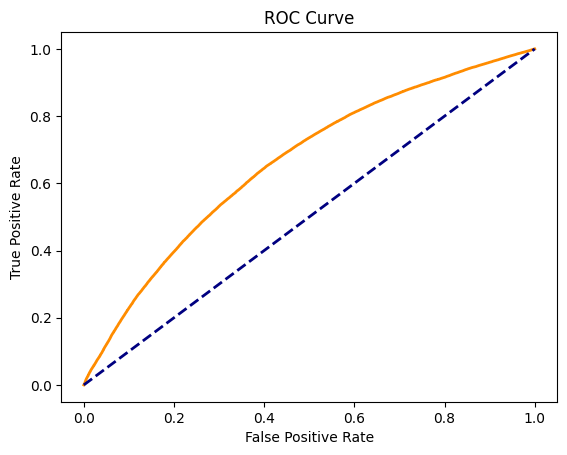

In [234]:
fpr, tpr, _ = roc_curve(y_test, prediction_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()